In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import statistics

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

base = automap_base()
base.prepare(autoload_with = engine)


In [6]:
# View all of the classes that automap found

base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.

date_list = session.query(measurement.date)
recent_date = [x[0] for x in date_list]
recent_date = max(recent_date)
recent_date


'2017-08-23'

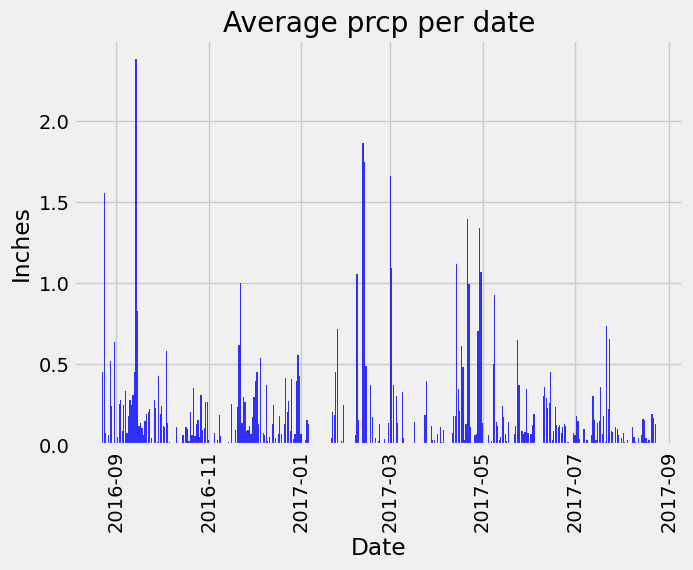

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

recent_date_clean = dt.datetime.strptime(recent_date, "%Y-%m-%d").date()
recent_date_clean

# Calculate the date one year from the last date in data set.

date_one_year = recent_date_clean - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

one_year_prec = session.query(measurement).filter(measurement.date >= date_one_year).filter(measurement.date <= recent_date_clean)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

prpc_dict = [{"date": x.date,
              "prcp": x.prcp} for x in one_year_prec]

prpc_df = pd.DataFrame(prpc_dict)

# Sort the dataframe by date

prpc_df["date"] = pd.to_datetime(prpc_df["date"])
prpc_df = prpc_df.sort_values("date")

grouped_prpc_df = prpc_df.groupby("date").mean()

# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize=[7,5])
ax.bar(grouped_prpc_df.index, grouped_prpc_df['prcp'], color='blue', alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.set_title('Average prcp per date')

for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 1 != 0:
        label.set_visible(False)

plt.xticks(rotation=90)

plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data

count = prpc_df["prcp"].count()
mean = prpc_df["prcp"].mean()
quartiles = prpc_df["prcp"].quantile([0.25,0.5,0.75])
st_dev_list = prpc_df.dropna(subset=["prcp"])
st_dev = statistics.stdev(st_dev_list["prcp"])
minimum = prpc_df["prcp"].min()
q_25 = quartiles[0.25]
q_50 = quartiles[0.5]
q_75 = quartiles[0.75]
maximum = prpc_df["prcp"].max()

stats_list = ["count",
              "mean",
              "std",
              "min",
              "25%",
              "50%",
              "75%",
              "max"]
value_list = [count,
              mean,
              st_dev,
              minimum,
              q_25,
              q_50,
              q_75,
              maximum]

stat_dict = {"stats": stats_list,
             "value": value_list}

stat_df = pd.DataFrame(stat_dict)
stat_df.head(8)

,stats,value
0,count,2021.000000
1,mean,0.177279
2,std,0.461190
3,min,0.000000
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset

number_stations = session.query(station.station).count()
number_stations


9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_list = session.query(measurement.station)

station_names = []
station_counts = []

for name in station_list:
    station_names.append(name)

station_names = set(station_names)
station_names = [x[0] for x in station_names]

for station in station_names:
    number_rows = session.query(measurement.station).filter(measurement.station == station).count()
    station_counts.append(number_rows)


active_stations_df = pd.DataFrame({"station": station_names,
                                   "number of rows": station_counts})

active_stations_df = active_stations_df.sort_values("number of rows",ascending=False)
active_stations_df = active_stations_df.reset_index(drop=True)
active_stations_df.head(len(station_names))



,station,number of rows
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temperature = session.query(measurement.tobs).filter(measurement.station == active_stations_df["station"][0])

temp_list = [x[0] for x in temperature]

max_temp = max(temp_list)
min_temp = min(temp_list)
mean_temp = statistics.mean(temp_list)

most_active_station_df = pd.DataFrame({"stat":["lowest value","highest value","average"],
                                       "value":[min_temp, max_temp, mean_temp]})
most_active_station_df.head()




,stat,value
0,lowest value,54.000000
1,highest value,85.000000
2,average,71.663781


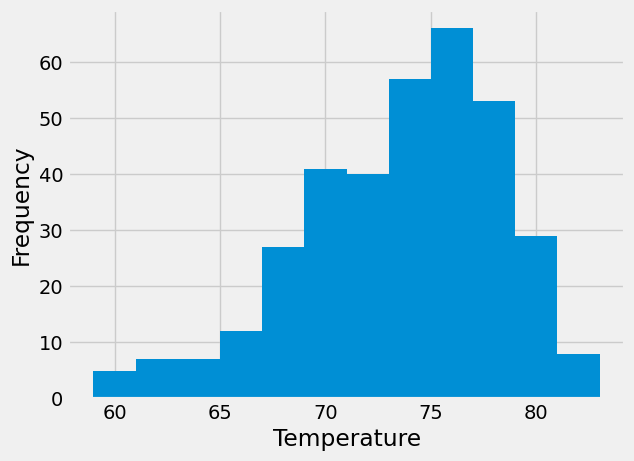

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12_months = session.query(measurement.tobs).filter(measurement.station == active_stations_df["station"][0]).filter(measurement.date >= date_one_year).filter(measurement.date <= recent_date_clean)

temp_list = [x[0] for x in last_12_months]

plt.hist(temp_list, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()



# Close Session

In [17]:
# Close Session
session.close()